In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag
from numpy import linalg as LA
from scipy import optimize

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
xinj_to_Einj = 4.698e-4/2. #Einj = 4.698e-4/2 xinj
mass_to_Einj = 1./2.
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass,  ' +r'$m_\mathrm{X}\quad[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"

label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_Gamma_stim = r"$\Gamma_X^\mathrm{stim}/\Gamma_X=[1+2n_\mathrm{Pl}(x_\mathrm{inj})]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'
sd = pi


find_nearests = sd.find_nearests
#from scipy.interpolate import interp1d

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict

def pi_run_pca_constraints_with_recfast(xinj_values,gammai_array,fdm,*args,**kwargs):
    PCA_eigen_modes = kwargs['PCA_modes']
    recfast = kwargs['recfast']
    f_dm_pca = {}
    f_dm_pca['curves'] = []
    f_dm_pca['xinj'] = []
    
    store_DXe_Xe = kwargs.get('store_DXe_Xe', 'no')
    
    
    z1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['z']
    E1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['values']
    z2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['z']
    E2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['values']
    z3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['z']
    E3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['values']
    
    f_E1 = interp1d(z1, E1)
    f_E2 = interp1d(z2, E2)
    f_E3 = interp1d(z3, E3)

    
    for xinj_asked in xinj_values:
        xdec = xinj_asked
        curves = {}
        curves['Gamma_inj'] = gammai_array
        if store_DXe_Xe == 'yes':
            curves['DXe_Xe'] = []

        #str_dir = str("%.3e"%xdec)

        recfast.rf_xinj0 = xdec
        recfast.rf_f_dec = fdm

        args = {}

        p_name = 'Gamma_dec'
        p_array = gammai_array

        args['param_values_array'] = p_array
        args['param_name'] = p_name
        args['save_recfast_results'] = 'no'
        #rf.save_dir_name = 'case_' + '_xdec_' + str_dir
        R = recfast.run_recfast_parallel(**args)


        recfast.rf_f_dec = 1.e-300
        #recfast.save_dir_name = 'case_no_inj' + '_xdec_' + str_dir
        R_no_inj = recfast.run_recfast_parallel(**args) 
        
        
        
        fdm_pca_array = []
        for k in range(len(R)):
            DXe_Xe = (R[k]['Xe']-R_no_inj[k]['Xe'])/R_no_inj[k]['Xe']
            z_Xe = R[k]['z']
            f_DXe_Xe = interp1d(z_Xe,DXe_Xe)
            
            min_z1 = max(np.min(z1),np.min(z_Xe))
            max_z1 = min(np.max(z1),np.max(z_Xe))

            min_z2 = max(np.min(z2),np.min(z_Xe))
            max_z2 = min(np.max(z2),np.max(z_Xe))

            min_z3 = max(np.min(z3),np.min(z_Xe))
            max_z3 = min(np.max(z3),np.max(z_Xe))
            
            new_z_min = max(min_z1,min_z2,min_z3)
            new_z_max = min(max_z1,max_z2,max_z3)
            
            new_z_min = 1e-5
            new_z_max = 4e3
            new_z = np.linspace(new_z_min,new_z_max,500)

            
            new_z1 = new_z#np.linspace(min_z1,max_z1,5000)
            new_z2 = new_z#np.linspace(min_z2,max_z2,5000)
            new_z3 = new_z#np.linspace(min_z3,max_z3,5000)
            
            zeta1 = f_DXe_Xe(new_z1)
            zeta2 = f_DXe_Xe(new_z2)
            zeta3 = f_DXe_Xe(new_z3)

            integrand_rho1 = zeta1*f_E1(new_z1)
            integrand_rho2 = zeta2*f_E2(new_z2)
            integrand_rho3 = zeta3*f_E3(new_z3)
            
            

            rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
            rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
            rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
            #print(rho1,rho2,rho3)

            sigma1 = 0.12
            sigma2 = 0.19
            sigma3 = 0.35

            fdm_pca_lim = 2.*1./np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
            fdm_pca_array.append(fdm_pca_lim)
            if store_DXe_Xe == 'yes':
                curves['DXe_Xe'].append([new_z,f_DXe_Xe(new_z)])
                
            
        fdm_pca_array = np.asarray(fdm_pca_array)
        curves['fdm'] = fdm_pca_array
        
        
        
        
        
        f_dm_pca['xinj'].append(xdec)
        f_dm_pca['curves'].append(curves)
    return f_dm_pca


import matplotlib.animation as animation

# what is going on with stimulated decay bottom corner?

In [9]:
sd_lib_extended_run_stim = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920',sd_lib_extended_run_stim)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [10]:
def pi_compute_fdm_constraints_stim(log10_tau_a,log10_Einj_in_ev,asd_lib,*args,**kwargs):
    Einj_in_ev = 10**log10_Einj_in_ev
    tau_a = 10**log10_tau_a
    #ma_in_ev = log10_ma_in_ev
    #tau_a = log10_tau_a
    xinj = Einj_in_ev/xinj_to_Einj
    #gagg = 3.57e7*(Gamma_values)**0.5*Xinj_values**(-3./2.)
    Gamma = 1./tau_a#((gagg/3.57e7)/xinj**(-3./2.))**2.
    
    mode ='' #fisher, QS or mu
    gamma_mu = 1e-8
    if (xinj >= 10. and Gamma < 2e-20): 
        mode = 'QS'
        Gamma_QS = 2e-20
    elif (xinj < 10. and Gamma < 2e-21*xinj):
        mode = 'QS'
        Gamma_QS = 2e-21*xinj
    elif (xinj >= (gamma_mu/1e-15) and Gamma > gamma_mu):
        mode = 'mu'
    elif (xinj < (gamma_mu/1e-15) and Gamma > 1e-15*xinj):
        mode = 'mu'
    else:
        mode = 'fisher'
        #mode = 'fisher'
    
    
    
    
    # for short lifetime, we compute the constraint
    # analytically using the mu-distortion
    if mode  == 'mu':
        ct = sd.cosmotherm()
        ct.ct_T0 = 2.7255
        ct.ct_Yp = 0.245407
        ct.ct_N_eff = 3.046
        ct.ct_Omega_m = 0.312331
        ct.ct_Omega_b = 0.0491137
        ct.ct_h = 0.675422
        
        
        cosmo = sd.cosmo()
        X_dm = sd.dm_particle()
        pi.set_dm_params_to_CT_pi_params(X_dm,ct)
        pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
        
        X_dm.Gamma_inj = Gamma
        X_dm.x_0 = xinj
        #fdm_constraint = np.abs(pi.high_redshift_f_dm_limit(7.4e-5,cosmo,ct,X_dm,N_int = 5))
        fdm_constraint = np.abs(sd.high_redshift_f_dm_limit(7.4e-5,cosmo,ct,X_dm,**kwargs))
        #fdm_constraint = 0.0001
    # for long lifetime, we compute the constraint
    # by extrapolating
    elif mode == 'QS':
        #fdm_constraint = 1e50
        xi_a = [xinj]
        Gamma_values = [Gamma_QS]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,asd_lib,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']*Gamma_QS/Gamma
    # for intermerdiate cases we compute the constraints using fisher matrix
    else:
        #fdm_constraint = 1e100
        xi_a = [xinj]
        Gamma_values = [Gamma]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,asd_lib,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']
        
    return np.log10(fdm_constraint)

pi_compute_fdm_constraints_stim = np.vectorize(pi_compute_fdm_constraints_stim)




In [12]:
firas = sd.firas()
edges = sd.edges()

add_edges = 'yes'

tau_values = np.linspace(5,34,200)
#tau_values = np.linspace(5,15,30)
Einj_values =np.linspace(-10,5,200)
xlist = Einj_values
ylist = tau_values

X, Y = np.meshgrid(xlist, ylist)

a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['stim'] = 'yes'
a_dict['N_int'] = 10

if add_edges == 'yes':
    a_dict['add_edges'] = 'yes'
else:
    a_dict['add_edges'] = 'no'

#lib = sd_lib_lyc_reio
lib = sd_lib_extended_run_stim
#lib = None


#Z = vfunc_tau_a_contours(Y,X,lib,**a_dict)
Z =  pi_compute_fdm_constraints_stim(Y,X,lib,**a_dict)

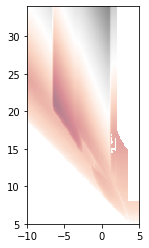

In [13]:
plt.imshow(Z, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
           cmap='RdGy', alpha=0.5)

In [14]:
# save the results

case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
     name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_stim_070920'
#name_ext += '_test'
np.shape(Z)
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'

    
np.savetxt(path, Z, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'


np.savetxt(path, X, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'


np.savetxt(path, Y, delimiter='\t', fmt='%.4e')





In [15]:
# load the results
case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_stim_070920'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

In [16]:
# load the non-thermal distorsion

NT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/E_gamma_nt.dat')
z_nt = NT[:,1]
E_nt = NT[:,0]

# f_nt = interp1d(z_nt,E_nt)


ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
pi.set_dm_params_to_CT_pi_params(X_dm,ct)
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

G_nt = []
for zx in z_nt:
    G_nt.append(pi.find_Gamma_inj_for_injection_redshift_zX(zx,cosmo,ct))
G_nt = np.asarray(G_nt)

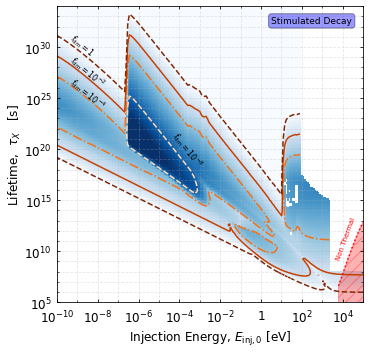

In [18]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5


tau_values = Yf[:,0]
Einj_values = Xf[0]

# tau_values = np.linspace(5,30,500)
# Einj_values =np.linspace(-10,5,500)

# tau_values = 10**Yf[0]
# Einj_values = 10**Xf[0]
# xlist = Einj_values
# ylist = tau_values

levels = [-8,-4,-2,0]

colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)

CS = ax.contour(Xf, Yf, Zf,levels,cmap = colormap,norm=normalize,linestyles=['--','-.','-','--'])


# CS.levels = [0.0001,0.01,1]


# # Label levels with specially formatted floats
# if plt.rcParams["text.usetex"]:
#     fmt = r'%r \%%'
# else:
#     fmt = r'$f_\mathrm{dm}=%r$'
    
# fmt = ticker.LogFormatterMathtext()

#ax.clabel(CS, CS.levels, inline=10, fontsize=8,fmt=fmt)
 

# masses_ev = np.logspace(-9,9,100)
# tau_dfsz = 1.1581e27*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_dfsz),c='k',lw=2,ls=':')
# tau_ksvz = 8.9078e23*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_ksvz),c='k',lw=2,ls=':')


ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')



ax.set_xlim(Einj_values[0],Einj_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
ax.set_ylim(tau_values[0],tau_values[-1])

ax.set_xlabel(label_injection_energy,size=title_size)
#ax.set_ylabel("coupling constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.11,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)


im = ax.imshow(Zf, extent=[-10,5,tau_values[0],tau_values[-1]], origin='lower',
           cmap=colormap2,norm=normalize, alpha=1.,aspect=0.5)


ax.text(-9.5, 31.5, r'$f_\mathrm{dm}=1$' , rotation = -40,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(-9.5, 29.5, r'$f_\mathrm{dm}=10^{-2}$' , rotation = -40,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(-9.5, 27.3, r'$f_\mathrm{dm}=10^{-4}$' , rotation = -40,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))



ax.text(-4.5, 22, r'$f_\mathrm{dm}=10^{-8}$' , rotation = -52,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(0.91, 0.29, r'Non Thermal' , rotation = 70,color='r',
        transform=ax.transAxes, fontsize=7, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))


ax.plot(np.log10(E_nt*1e3),np.log10(1./G_nt),c='red',ls=':')
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='r',alpha=0.3)
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='None',edgecolor='r')

ax.patch.set_color('white') # or whatever color you like
ax.patch.set_alpha(.2)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$1$',r'$10^{2}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{5}$',r'$10^{10}$',r'$10^{15}$',r'$10^{20}$',r'$10^{25}$',r'$10^{30}$'])

        
ax.text(0.5, 33, 'Stimulated Decay', fontsize=9, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor='blue', alpha=0.4))



fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '.pdf'

plt.savefig(path_to_figures + '/figures_for_paper_tau_a_final_stim' + name_ext)

# final versions of the figures with  distortions

In [37]:
sd_lib_raw_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('raw_lyc_reio',sd_lib_raw_lyc_reio)

sd_lib_bare = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('bare',sd_lib_bare)


sd_lib_lyc = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8cbe1c88>


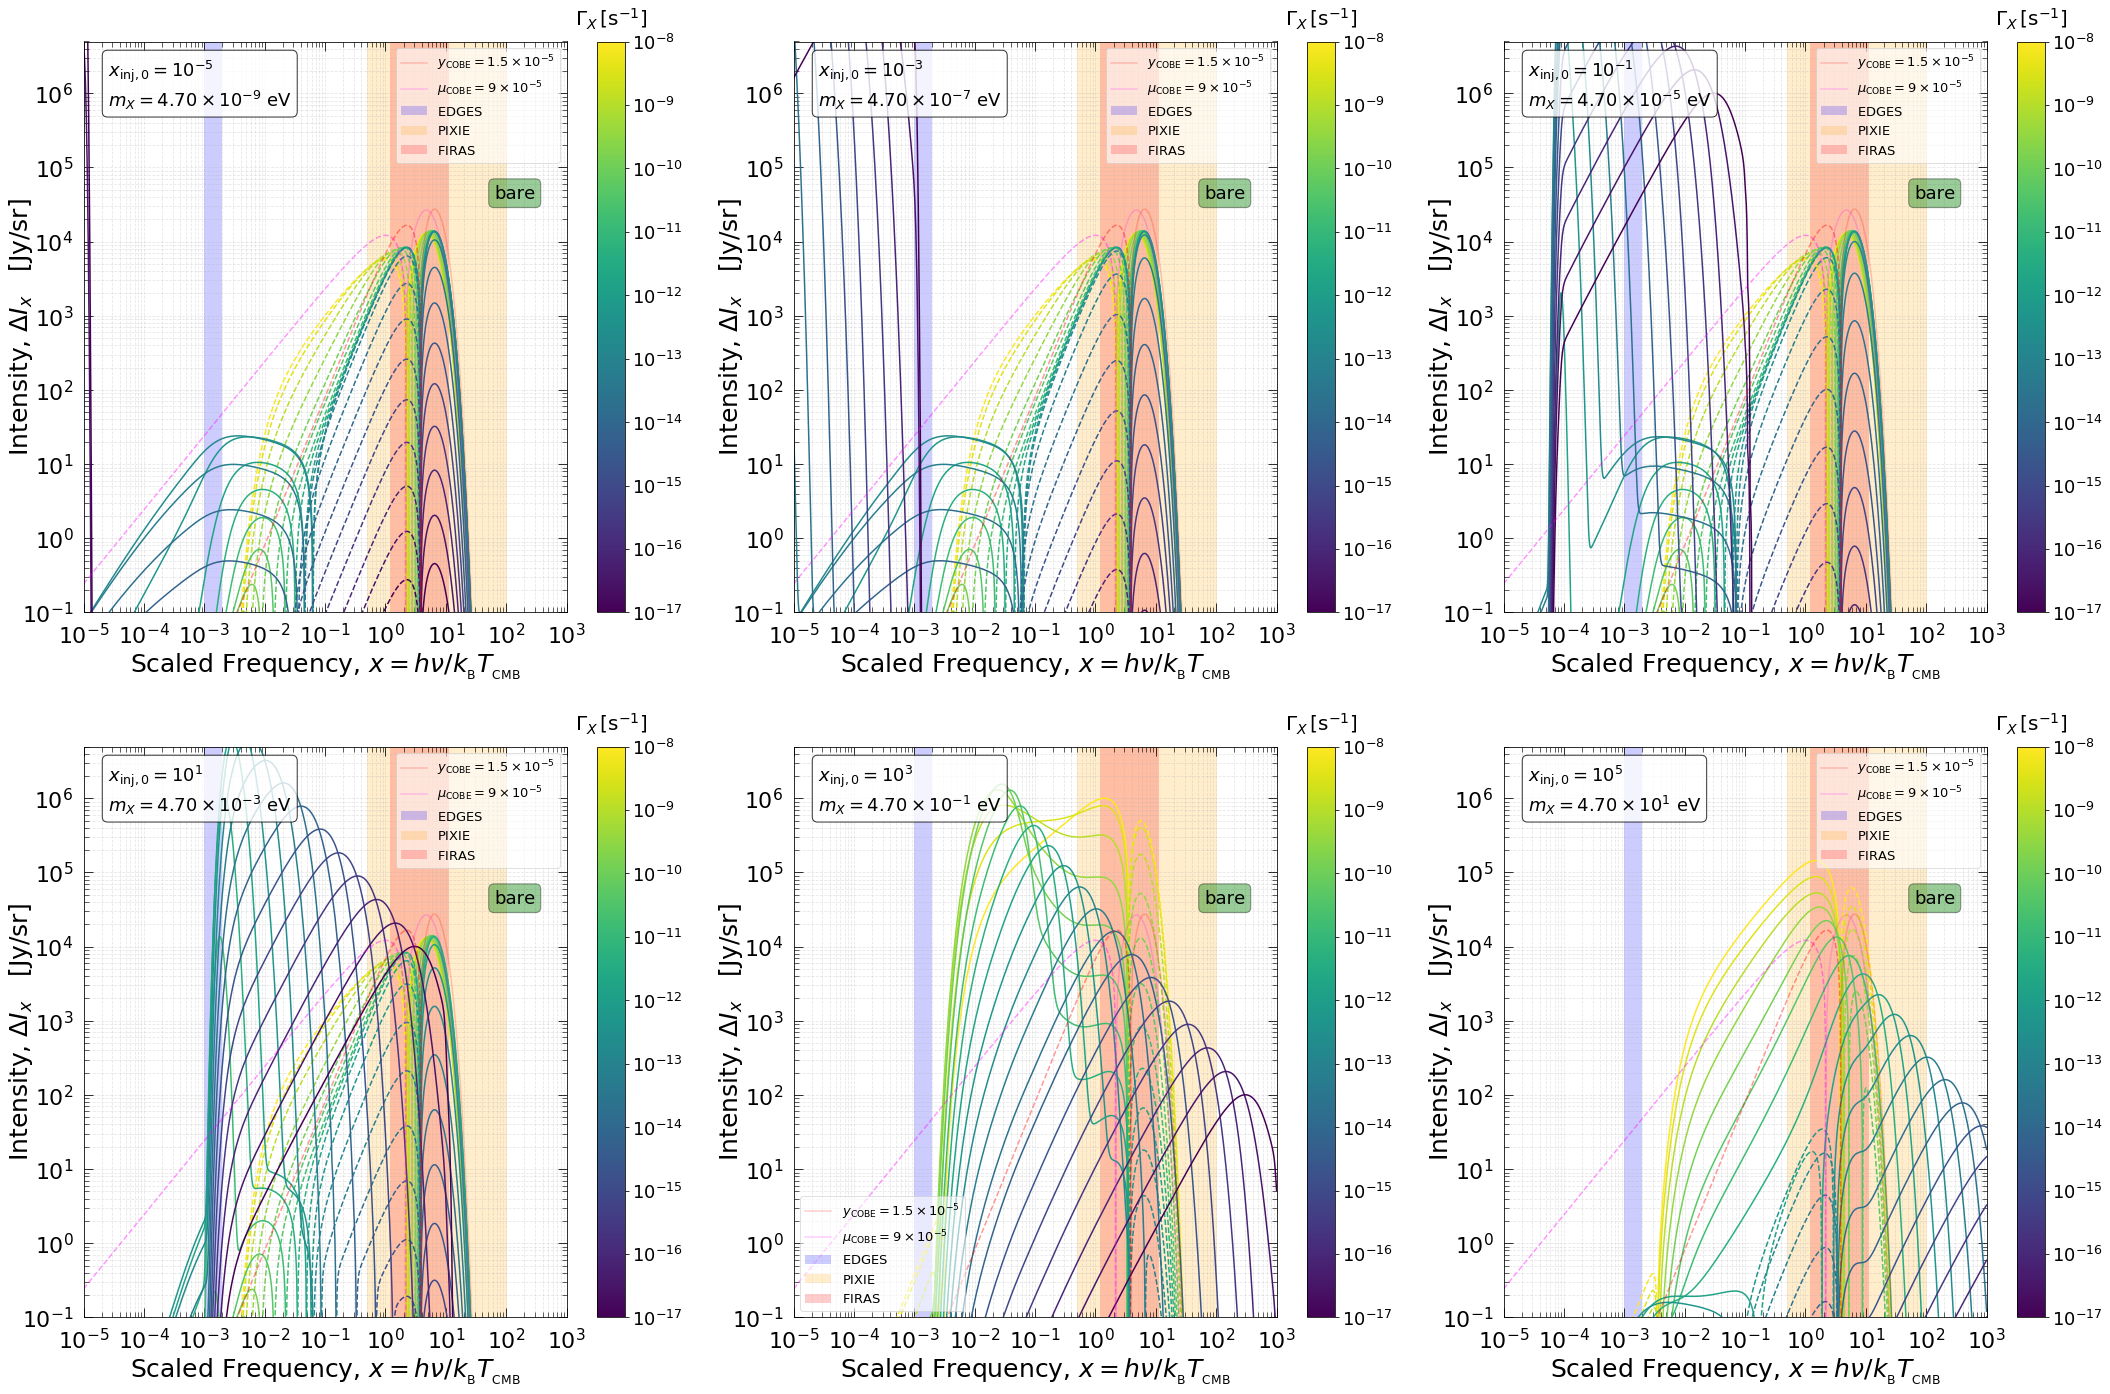

In [39]:
firas = sd.firas()
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)

xinj_asked_array = [1.e-5,1e-3,1e-1,1e1,1e3,1e5]

# x_min = 1.e-6
# x_max = 1.5e4
# ymin = 1.e-18
# ymax = 1.5e-3
x_min = 1.e-5
x_max = 1.e3
ymin = 1.e-1
ymax = 5e-6*1e6*1e6

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 22
title_size = 25
legend_size = 28
handle_length = 1.5
my_cmap =  cm.get_cmap('viridis')
#my_cmap = my_cmap(np.linspace(0.,0.5,ngamma))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax) in zip(xinj_asked_array,ax_array.reshape(-1)):



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)
    
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=18)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=20,pad=15)





#     ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
#     ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

#     plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
#     plt.setp(ax.get_xticklabels(), fontsize=label_size)
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
#     majors = [0, 1, 5]
# #     majors = [0, 1, 5]
#    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False) #(3)


#     ax.xaxis.set_ticks_position('both')
#     ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
#                                           numticks=12)
#     ax.xaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    #ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    color=iter(cm.viridis(np.linspace(1.,0.,ngamma)))

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    str_m_dec_in_ev =  str("%.3e"%m_dec_in_ev)
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'

    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_bare)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()

    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.05, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=18, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.2,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.2,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)

        
    if xinj_asked==1e3:
        lloc = 3
    else:
        lloc =1
    legend1 = ax.legend(loc=lloc,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)

    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    case_type = 'bare'
    case_color ='green'
    ax.text(0.85, 0.75, case_type, transform=ax.transAxes, fontsize=18, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.4))

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_bare_final_version.pdf')
plt.show()
plt.close(fig)





[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8b2a05f8>


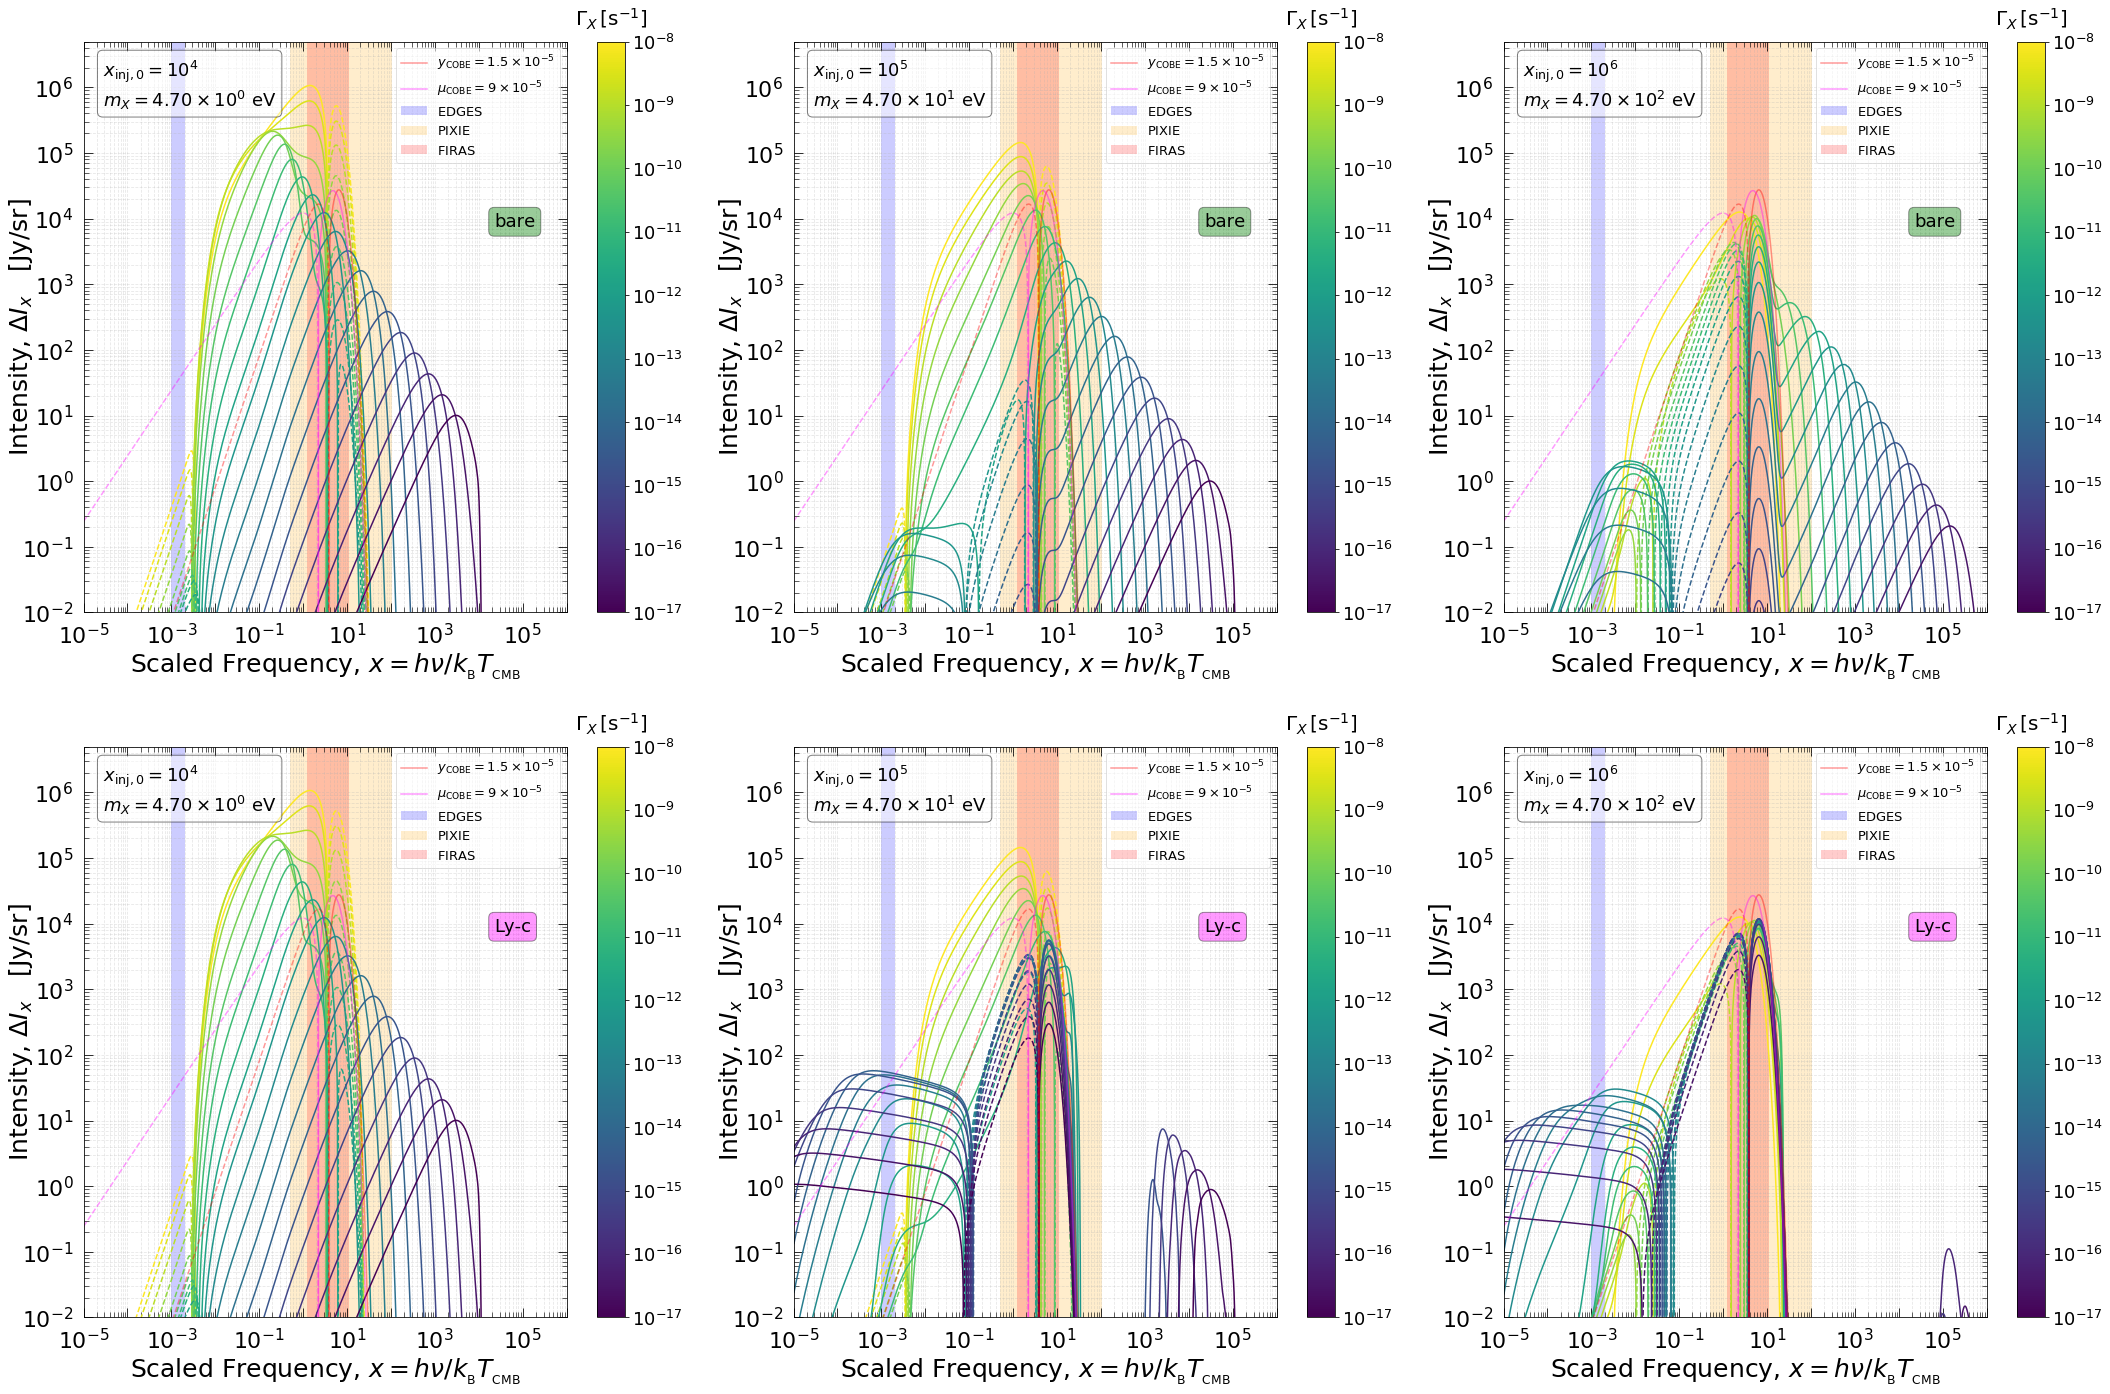

In [44]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
xinj_to_mass = 4.698e-4 #in ev
xinj_asked_array = [1.e4,1e5,1e6,1.e4,1e5,1e6]

x_min = 1.e-5
x_max = 1.e6
ymin = 1.e-14*1e12
ymax = 5e-6*1e12

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 22
title_size = 25
legend_size = 28
handle_length = 1.5

my_cmap =  cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax,iax) in zip(xinj_asked_array,ax_array.reshape(-1),np.arange(6)):
    if iax in (0,1,2):
        sd_lib = sd_lib_bare
        color=iter(cm.viridis(np.linspace(1,0,ngamma)))
        case_type = 'bare'
        case_color ='green'
    else:
        sd_lib = sd_lib_lyc
        color=iter(cm.viridis(np.linspace(1,0,ngamma)))
        case_type = 'Ly-c'
        case_color ='magenta'
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=18)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=20,pad=15)



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')

    
    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)


        
    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'
    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()
    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.04, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=18, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    
    ax.text(0.85, 0.7, case_type, transform=ax.transAxes, fontsize=18, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.4))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.4,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.4,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)
    
    legend1 = ax.legend(loc=1,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) #(3)
    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_bare_vs_lyc_final_version.pdf')
plt.show()
plt.close(fig)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8c879f98>


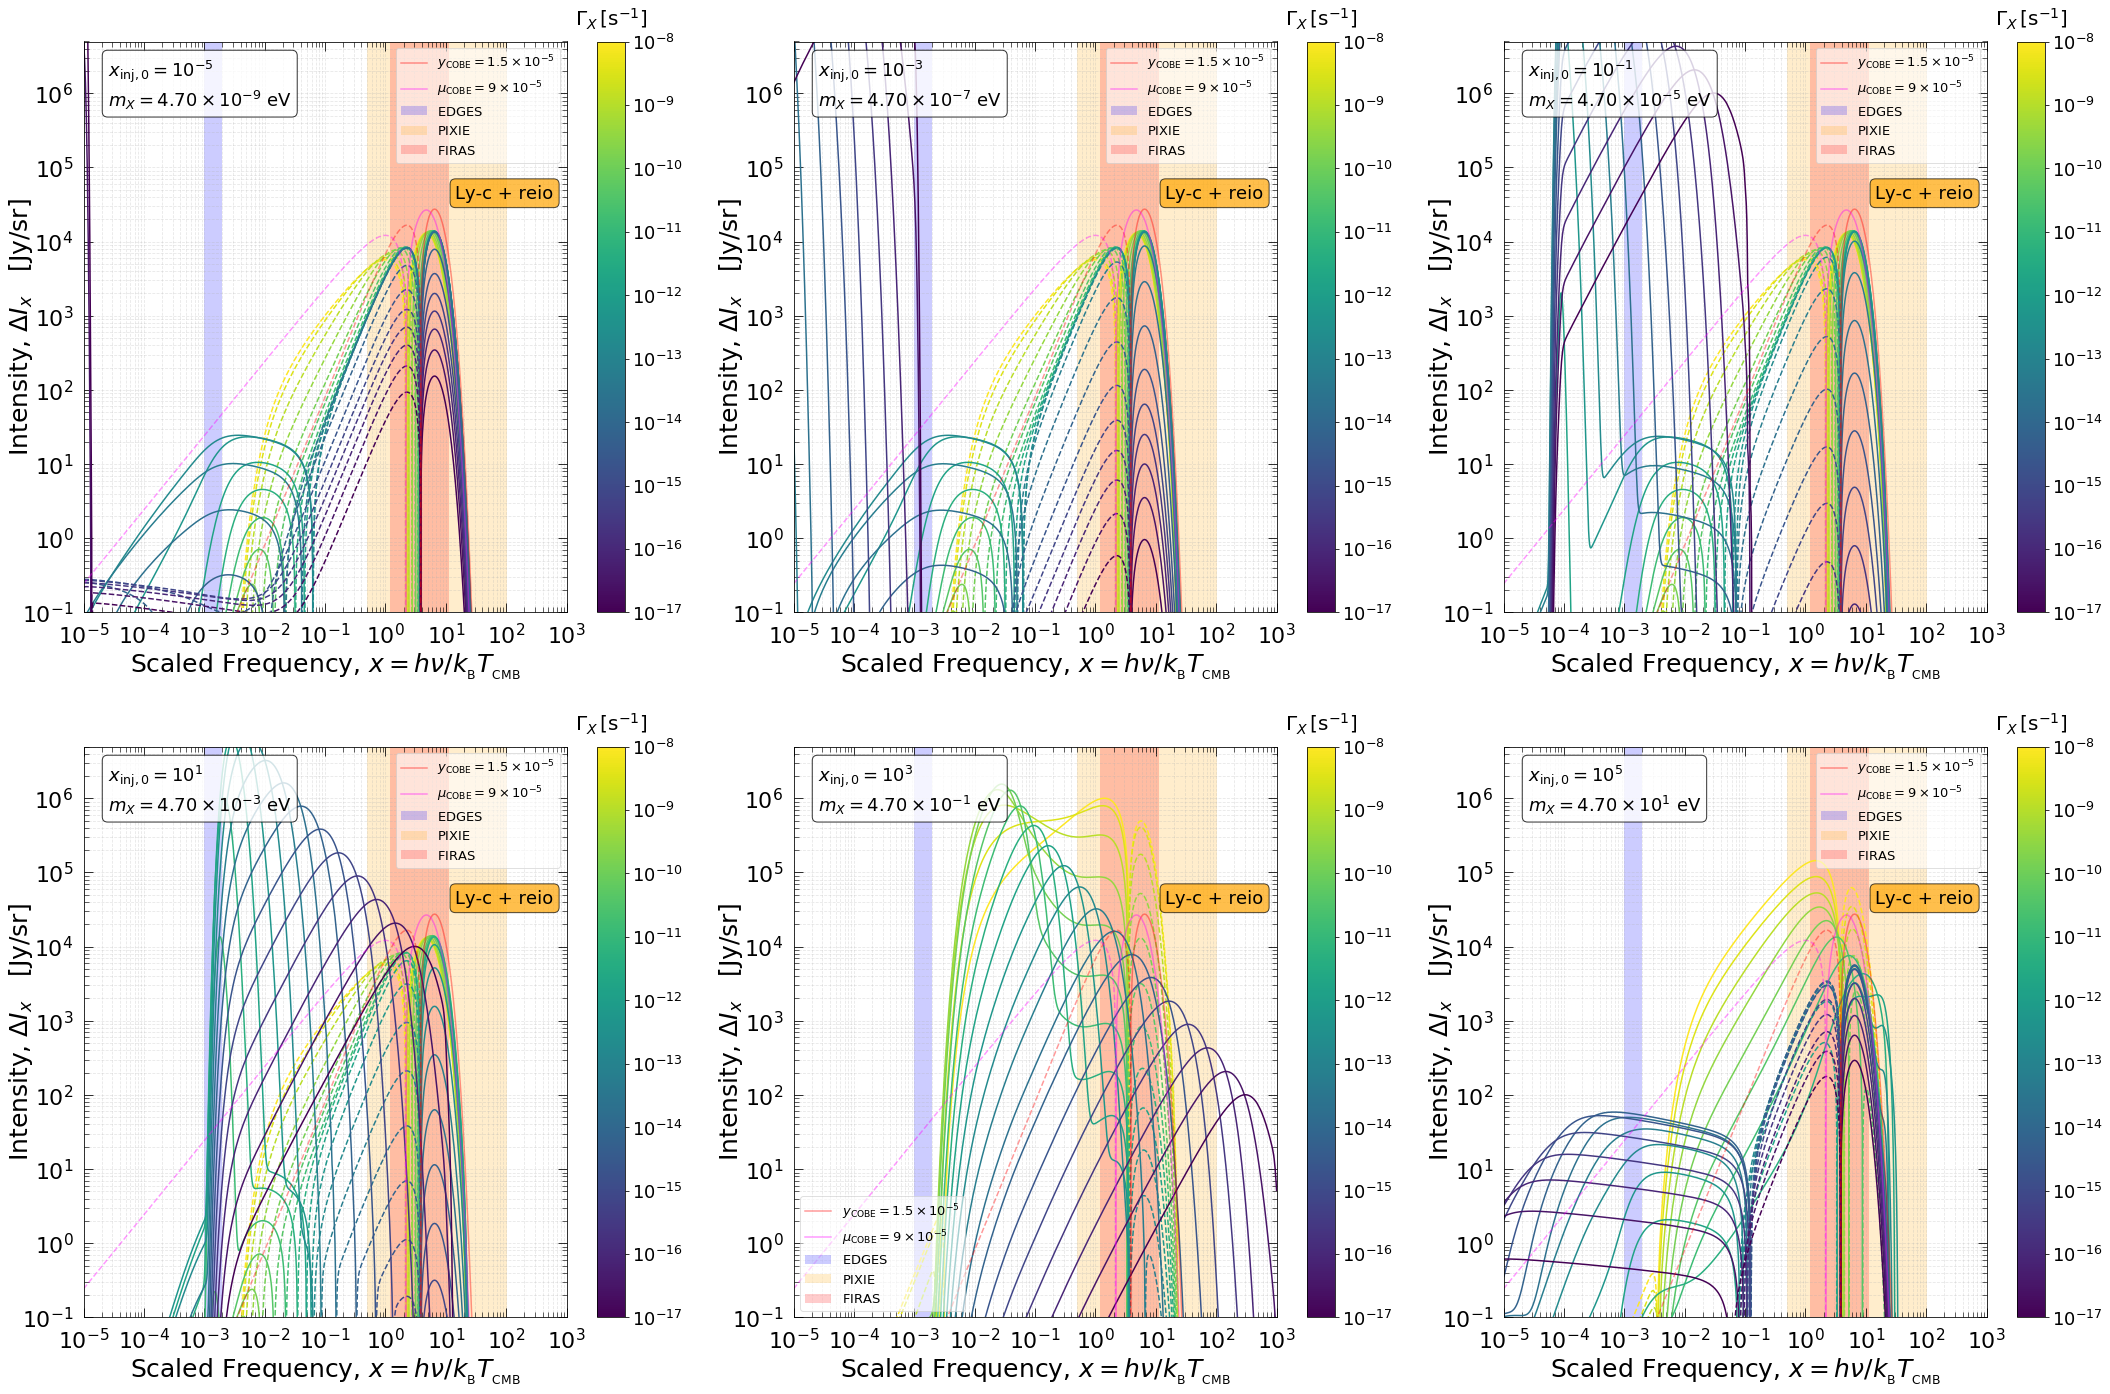

In [47]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)

xinj_asked_array = [1.e-5,1e-3,1e-1,1e1,1e3,1e5]

# x_min = 1.e-6
# x_max = 1.5e4
# ymin = 1.e-18
# ymax = 1.5e-3
x_min = 1.e-5
x_max = 1.e3
ymin = 1.e-1
ymax = 5e-6*1e6*1e6

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 22
title_size = 25
legend_size = 28
handle_length = 1.5

my_cmap =  cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax) in zip(xinj_asked_array,ax_array.reshape(-1)):



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)
    
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=18)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=20,pad=15)





#     ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
#     ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

#     plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
#     plt.setp(ax.get_xticklabels(), fontsize=label_size)
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
#     majors = [0, 1, 5]
# #     majors = [0, 1, 5]
#    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False) #(3)


#     ax.xaxis.set_ticks_position('both')
#     ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
#                                           numticks=12)
#     ax.xaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    #ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    color=iter(cm.viridis(np.linspace(1,0,ngamma)))

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    str_m_dec_in_ev =  str("%.3e"%m_dec_in_ev)
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'

    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()

    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.05, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=18, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.4,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.4,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)
    
    
    if xinj_asked==1e3:
        lloc = 3
    else:
        lloc =1
    legend1 = ax.legend(loc=lloc,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)

    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    case_type = 'Ly-c + reio'
    case_color ='orange'
    ax.text(0.77, 0.75, case_type, transform=ax.transAxes, fontsize=18, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.7))
        
    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_lyc_reio_final_version.pdf')
plt.show()
plt.close(fig)





# some standard mu and y to discuss hubble cooling

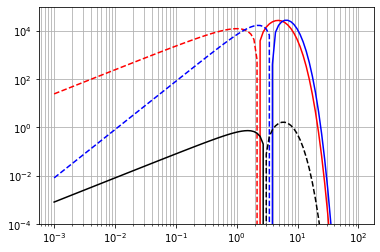

In [36]:
x_array = np.logspace(-3,2,100)
mu_array = sd.GetMuSpecDistAtTandX_chluba(9e-5,2.725,x_array)*1e6
y_array = sd.GetYSpecDistAtTandX(1.5e-5,2.725,x_array)*1e6
plt.plot(x_array,mu_array,c='r')
plt.plot(x_array,-mu_array,c='r',ls='--')
plt.plot(x_array,y_array,c='b')
plt.plot(x_array,-y_array,c='b',ls='--')
mu_cooling = sd.GetMuSpecDistAtTandX_chluba(-3e-9,2.725,x_array)*1e6
y_cooling = sd.GetYSpecDistAtTandX(-0.5e-9,2.725,x_array)*1e6
plt.plot(x_array,mu_cooling+y_cooling,c='k')
plt.plot(x_array,-mu_cooling-y_cooling,c='k',ls='--')
plt.loglog()
plt.ylim(1e-4,1e5)
plt.grid(which='both')


In [28]:
xinj_to_Einj*1e9

234900.0

In [30]:
'%.4e'%(1e5/xinj_to_Einj)

'4.2571e+08'

# new library at high frequency

In [2]:
sd_lib_extended_run_high_xinj = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_high_xinj_160920',sd_lib_extended_run_high_xinj)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920',sd_lib_extended_run_stim)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [9]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_190820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [14]:
def pi_compute_fdm_constraints(log10_tau_a,log10_Einj_in_ev,asd_lib,*args,**kwargs):
    
    asd_lib_high_xinj0 = kwargs.get('asd_lib_high_xinj0',None)
    
    Einj_in_ev = 10**log10_Einj_in_ev
    tau_a = 10**log10_tau_a
    #ma_in_ev = log10_ma_in_ev
    #tau_a = log10_tau_a
    xinj = Einj_in_ev/xinj_to_Einj
    #gagg = 3.57e7*(Gamma_values)**0.5*Xinj_values**(-3./2.)
    Gamma = 1./tau_a#((gagg/3.57e7)/xinj**(-3./2.))**2.
    lib_for_constraints = asd_lib
    if asd_lib_high_xinj0:
        if xinj>1e4 and Gamma<1e-14:
            lib_for_constraints = asd_lib_high_xinj0
            
    
    # for short lifetime, we compute the constraint
    # analytically using the mu-distortion
    if Gamma>1e-8:
        ct = sd.cosmotherm()
        ct.ct_T0 = 2.7255
        ct.ct_Yp = 0.245407
        ct.ct_N_eff = 3.046
        ct.ct_Omega_m = 0.312331
        ct.ct_Omega_b = 0.0491137
        ct.ct_h = 0.675422
        
        
        cosmo = sd.cosmo()
        X_dm = sd.dm_particle()
        pi.set_dm_params_to_CT_pi_params(X_dm,ct)
        pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
        
        X_dm.Gamma_inj = Gamma
        X_dm.x_0 = xinj
        fdm_constraint = np.abs(pi.high_redshift_f_dm_limit(7.4e-5,cosmo,ct,X_dm,N_int = 5))
    # for long lifetime, we compute the constraint
    # by extrapolating
    elif Gamma < lib_for_constraints.Gamma_inj_min:
        xi_a = [xinj]
        Gamma_values = [lib_for_constraints.Gamma_inj_min]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,lib_for_constraints,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']*asd_lib.Gamma_inj_min/Gamma
    # for intermerdiate cases we compute the constraints using fisher matrix
    else:
        xi_a = [xinj]
        Gamma_values = [Gamma]
        D = sd.pi_run_fisher_constraints(Gamma_values,xi_a,lib_for_constraints,**kwargs)
        fdm_constraint = D['curves'][0]['fdm']
    return np.log10(fdm_constraint)

pi_compute_fdm_constraints = np.vectorize(pi_compute_fdm_constraints)






In [19]:
firas = sd.firas()
edges = sd.edges()

add_edges = 'yes'

#tau_values = np.linspace(13,20,50)
#Einj_values =np.linspace(0,5,50)

tau_values = np.linspace(5,30,200)
Einj_values =np.linspace(-10,5,200)

xlist = Einj_values
ylist = tau_values

X, Y = np.meshgrid(xlist, ylist)

a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges

if add_edges == 'yes':
    a_dict['add_edges'] = 'yes'
else:
    a_dict['add_edges'] = 'no'

#lib = sd_lib_lyc_reio
lib = sd_lib_extended_run
a_dict['asd_lib_high_xinj0'] = sd_lib_extended_run_high_xinj

#Z = vfunc_tau_a_contours(Y,X,lib,**a_dict)
Z =  pi_compute_fdm_constraints(Y,X,lib,**a_dict)

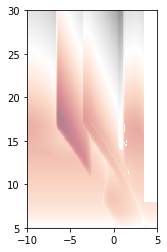

In [20]:
plt.imshow(Z, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
           cmap='RdGy', alpha=0.5)

In [21]:
# save the results

case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
     name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_190820'
#name_ext += '_test'
np.shape(Z)
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'

    
np.savetxt(path, Z, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'


np.savetxt(path, X, delimiter='\t', fmt='%.4e')

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'


np.savetxt(path, Y, delimiter='\t', fmt='%.4e')





In [23]:
# load the results
case = 'lyc+reio'
name_ext = ''
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
name_ext += '_extended_run_190820'
#name_ext += '_test'
path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Einj_in_ev' + name_ext + '.txt'
Xf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_Tau_X_in_s' + name_ext + '.txt'
Yf = np.loadtxt(path)

path = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/f_dm_constraints/log10_f_dm' + name_ext + '.txt'
Zf = np.loadtxt(path)

In [24]:
# load the non-thermal distorsion

NT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/E_gamma_nt.dat')
z_nt = NT[:,1]
E_nt = NT[:,0]

# f_nt = interp1d(z_nt,E_nt)


ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
pi.set_dm_params_to_CT_pi_params(X_dm,ct)
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

G_nt = []
for zx in z_nt:
    G_nt.append(pi.find_Gamma_inj_for_injection_redshift_zX(zx,cosmo,ct))
G_nt = np.asarray(G_nt)

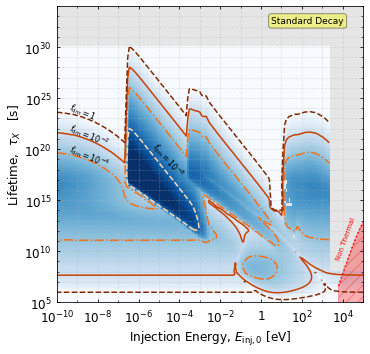

In [25]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
label_size = 12
title_size = 12
legend_size = 25
handle_length = 1.5


tau_values = Yf[:,0]
Einj_values = Xf[0]

# tau_values = np.linspace(5,30,500)
# Einj_values =np.linspace(-10,5,500)

# tau_values = 10**Yf[0]
# Einj_values = 10**Xf[0]
# xlist = Einj_values
# ylist = tau_values

levels = [-8,-4,-2,0]

colormap = plt.cm.Oranges #or any other colormap
colormap2 = plt.cm.Blues_r
colormap2 = colormap2
normalize = matplotlib.colors.Normalize(vmin=-10, vmax=0)

CS = ax.contour(Xf, Yf, Zf,levels,cmap = colormap,norm=normalize,linestyles=['--','-.','-','--'])


# CS.levels = [0.0001,0.01,1]


# # Label levels with specially formatted floats
# if plt.rcParams["text.usetex"]:
#     fmt = r'%r \%%'
# else:
#     fmt = r'$f_\mathrm{dm}=%r$'
    
# fmt = ticker.LogFormatterMathtext()

#ax.clabel(CS, CS.levels, inline=10, fontsize=8,fmt=fmt)
 

# masses_ev = np.logspace(-9,9,100)
# tau_dfsz = 1.1581e27*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_dfsz),c='k',lw=2,ls=':')
# tau_ksvz = 8.9078e23*masses_ev**-5
# ax.plot(np.log10(masses_ev*mass_to_Einj),np.log10(tau_ksvz),c='k',lw=2,ls=':')


ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)



ax.grid( b=True, which="both", alpha=0.3, linestyle='--')



ax.set_xlim(Einj_values[0],Einj_values[-1])
#ax.set_ylim(tau_values[0],tau_values[-1])
ax.set_ylim(tau_values[0],34)

ax.set_xlabel(label_injection_energy,size=title_size)
#ax.set_ylabel("coupling constant, "+r'$g_\mathrm{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$',size=title_size)
ax.set_ylabel(label_Tau_x,size=title_size)

ax.yaxis.set_label_coords(-.11,0.5)
ax.xaxis.set_label_coords(0.5,-.09)


# im = ax.imshow(Zf, extent=[Einj_values[0], Einj_values[-1],tau_values[0],tau_values[-1]], origin='lower',
#            cmap=colormap2,norm=normalize, alpha=1.)


im = ax.imshow(Zf, extent=[-10,5,tau_values[0],
                           tau_values[-1]],
               origin='lower',
           cmap=colormap2,norm=normalize, alpha=1.,aspect=0.5)


ax.text(-9.5, 24.8, r'$f_\mathrm{dm}=1$' , rotation = -23,
          fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(-9.5, 22.8, r'$f_\mathrm{dm}=10^{-2}$' , rotation = -23,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(-9.5, 20.8, r'$f_\mathrm{dm}=10^{-4}$' , rotation = -23,
         fontsize=8, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))



ax.text(-5.5, 21, r'$f_\mathrm{dm}=10^{-8}$' , rotation = -49,
        fontsize=8, 
          verticalalignment='top',color='k',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))

ax.text(0.91, 0.29, r'Non Thermal' , rotation = 70,color='r',
        transform=ax.transAxes, fontsize=7, 
          verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='grey', alpha=0.))


ax.plot(np.log10(E_nt*1e3),np.log10(1./G_nt),c='red',ls=':')
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='r',alpha=0.3)
ax.fill_between(np.log10(E_nt*1e3),0,np.log10(1./G_nt),hatch='//',color='None',edgecolor='None')

ax.patch.set_color('grey') # or whatever color you like
ax.patch.set_alpha(.2)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticklabels([r'$10^{-10}$',r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$1$',r'$10^{2}$',r'$10^{4}$'])
ax.set_yticklabels([r'$10^{5}$',r'$10^{10}$',r'$10^{15}$',r'$10^{20}$',r'$10^{25}$',r'$10^{30}$'])


ax.text(0.5, 33., 'Standard Decay', fontsize=9, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))

fig.tight_layout()
#plt.legend()


name_ext = ''
case = 'lyc+reio'
if case == 'lyc+reio':
    name_ext += '_lyc_reio'
elif case == 'bare':
    name_ext += '_bare'
if add_edges == 'yes':
    name_ext += '_with_edges'
else:
    name_ext += '_no_edges'
name_ext += '_extended_run'
name_ext += '.pdf'

plt.savefig(path_to_figures + '/figures_for_paper_tau_a_final' + name_ext)

# try running some cases with the new starting redshift

In [22]:
xinj_values = [1e7]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

Drho_rho = 3e-5

ct = pi.cosmotherm()
# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho


# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
# ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_Gamma_dec = 1e-20
ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 1
ct.ct_pi_energy_norm = 2
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

ct.pi_use_zstart_from_total_energy_fraction = 'yes'
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

(1e-06, 1000000.0)

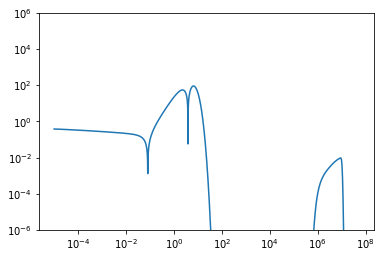

In [10]:
plt.plot(R[0]['x'],np.abs(R[0]['DI']))
plt.loglog()
plt.ylim(1.e-6,1e6)

(1e-06, 1000000.0)

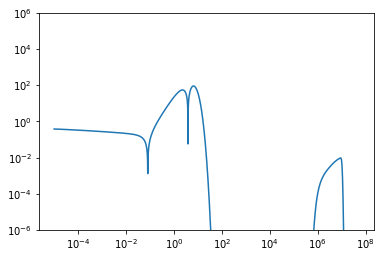

In [8]:
plt.plot(R[0]['x'],np.abs(R[0]['DI']))
plt.loglog()
plt.ylim(1.e-6,1e6)

# finding redshift of max injection given Gamma and xinj

In [2]:
# set cosmo to CT params:
ct = sd.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422


cosmo = sd.cosmo()
X_dm = sd.dm_particle()
pi.set_dm_params_to_CT_pi_params(X_dm,ct)
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)


In [3]:
gamma_inj = 1e-13
xinj = 1e0


In [12]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e7]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct = pi.cosmotherm()
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
# ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 2
ct.ct_reionisation_model = 1
ct.ct_only_global_energetics = 1
ct.ct_Gamma_dec = 1e-17


#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

In [13]:
R

[{'photon injection x_dec': 10000000.0,
  'z': array([4.95000000e+06, 4.90050000e+06, 4.85149500e+06, ...,
         2.02045515e-02, 2.00025060e-02, 1.00000000e-02]),
  '(NX/Nxini)': array([1.        , 1.        , 1.        , ..., 0.01408973, 0.01407711,
         0.01346167]),
  '(NX/Nxini)_stim': array([1.        , 1.        , 1.        , ..., 0.01408973, 0.01407711,
         0.01346167]),
  't_cosmic': array([9.73261730e+05, 9.93020582e+05, 1.01318055e+06, ...,
         4.26230886e+17, 4.26320514e+17, 4.30790901e+17]),
  't_stim': array([2.13728579e+06, 2.16301668e+06, 2.18912796e+06, ...,
         4.26230886e+17, 4.26320514e+17, 4.30790901e+17]),
  '[(dlnRho/dln1pz)/(dRho/Rho)_inj]': array([7.02130919e-22, 9.24701166e-22, 1.21043750e-21, ...,
         2.18474086e-01, 2.18342705e-01, 2.11871181e-01]),
  'finj': 2.8329527483597916e-11}]

10000000.0 15.203283774697056


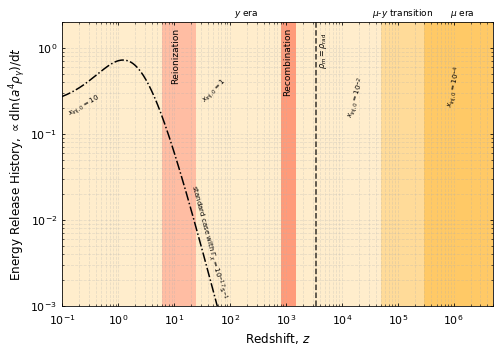

1e-17


In [14]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5


x_min = 1.e-1
x_max = 5.e6
x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.98, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9,verticalalignment='top')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.98, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9,verticalalignment='top')



color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))

i = 0
for r,Gamma_asked in zip(R,xinj_values):
    xinj0 = r['photon injection x_dec']
    gamma_inj = ct.ct_Gamma_dec
    #zX = sd.injection_redshift_zX_stim(gamma_inj,xinj0,cosmo,ct)
    #print(zX)
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$x_\mathrm{inj,0} = $"+scientific_notation(Gamma_asked)
    if i==0:
        ax.plot(r["z"],r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"],c='k',ls='-.',alpha=1.,label=slabel)

    else:
        ax.plot(r["z"],r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"],c=col,ls='-',alpha=1.,label=slabel)
    
    Int_rho = []
    for zp in r["z"]:
        Int_rho.append(np.trapz(-r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"][r["z"]>zp],np.log(1.+r["z"][r["z"]>zp])))
    Int_rho = np.asarray(Int_rho)
    f = interp1d(np.log(1.+r["z"]),Int_rho) 
    def f10(ln1pz):
        return f(ln1pz)-0.01
    zinj10 = np.exp(optimize.brentq(f10, np.log(1.+max(r["z"])), np.log(1.+min(r["z"]))))-1.
    print(xinj0,zinj10)
    #ax.plot(r["z"],r["(NX/Nxini)_stim"],c=col,ls='--',alpha=1.)
    
    #ct.ct_Gamma_dec = Gamma_asked
    #cosmo = pi.cosmo()
    #pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    #try:
    #    zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    #except:
    #    zX = 0.
    i+=1
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.595, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)




ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-75)

ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=30)


ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=45)

ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=73)


ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)



#ax.legend()

ax.loglog()

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_drho_rho_energy_mode_G_1e-17.pdf')
plt.show()
plt.close(fig)
print(ct.ct_Gamma_dec)

In [49]:

max(ct.ct_zlate,1e2)

1000.0

In [40]:
Int_rho = []
for zp in r["z"]:
    Int_rho.append(np.trapz(-r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"][r["z"]<zp],np.log(1.+r["z"][r["z"]<zp])))
Int_rho = np.asarray(Int_rho)
f = interp1d(np.log(1.+r["z"]),Int_rho) 

In [41]:
Int_rho

array([1.00000054, 1.00000054, 1.00000054, ..., 0.00211983, 0.        ,
       0.        ])